In [29]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
import numpy as np

In [94]:
class stockpredictor:
  def __init__(self,ticker):
    self.ticker=ticker
    self.model=RandomForestClassifier(n_estimators=500,min_samples_split=50,random_state=1)
    self.predictors=[]
    self.data=None
    self.getdata()
    self.dressdata()
  
  def getdata(self):
    self.data=yf.Ticker(self.ticker).history(period="max")
    self.data['Tomorrow']=self.data.shift(-1)['Close']
    self.data['Target']=(self.data['Tomorrow']>self.data['Close']).astype(int)
    self.data=self.data.dropna()

  def dressdata(self):
    averagewindow=[2,10,50,100,400,1000]
    self.predictors=[]
    for h in averagewindow:
      ravg=self.data.rolling(h).mean()

      ratio=f"CloseRatio_{h}"
      self.data[ratio]=self.data['Close']/ravg['Close']

      trend=f"Trend_{h}"
      self.data[trend]=self.data.shift(1).rolling(h).sum()['Target']
    
      volatility=f"Volat_{h}"
      self.data[volatility]= np.log((((self.data["Close"]-ravg["Close"])**2).rolling(h).sum()/h)**0.5)

      self.predictors +=[ratio,trend]#,volatility]
    self.data.replace([np.inf, -np.inf], np.nan, inplace=True)
    self.data=self.data.dropna()

  def Predict(self,train,test):
    self.model.fit(train[self.predictors],train["Target"])
    predicts=self.model.predict_proba(test[self.predictors])[:,1]

    predicts[predicts>=0.6]=1
    predicts[predicts<0.6]=0

    return pd.concat([test["Target"],pd.Series(predicts,index=test.index,name="Predictions")],axis=1)
  
  def backtest(self,start=2500,step=250):
    allpredict=[]
    for i in range(start,self.data.shape[0],step):
      train,test=self.data.iloc[0:i].copy(),self.data.iloc[i:i+step].copy()
      predicts=self.Predict(train,test)
      allpredict.append(predicts)
    return pd.concat(allpredict)

  def result(self,data):
    return self.model.predict_proba(data[self.predictors])[:,1]
  
  def plotter(self,predictions):
    Yearu=[[],[]]
    Yeard=[[],[]]
    UP=[[],[]]
    DOWN=[[],[]]
    dd=[]
    dc=[]
    pid=predictions.index
    data=self.data
    for j in range(2):
      val='Target' if j==0 else 'Predictions'

      for i in range(len(pid)):
        temp=predictions.iloc[i][val]
        if temp==0:
          Yeard[j].append(pid[i])
          DOWN[j].append(data.loc[pid[i]]['Close'])
        else:
          Yearu[j].append(pid[i])
          UP[j].append(data.loc[pid[i]]['Close'])
        "sad"
        if j==0:
          dd.append(pid[i])
          dc.append(data.loc[pid[i]]['Close'])
    for j in range(2):
     plt.subplot(1,2,j+1)
     plt.scatter(Yeard[j],DOWN[j],color='red',alpha=0.5,s=0.125)
     #plt.scatter(dd,dc,alpha=0.1,s=0.1)
     plt.scatter(Yearu[j],UP[j],color='green',alpha=0.5,s=0.12)
     plt.title(self.ticker+ ('Target' if j==0 else 'Prediction'))
     
     plt.grid(which='major')
    plt.show()
    print("Red: Went-down; Green: Went-up; precision = {}".format(precision_score(predictions['Target'],predictions['Predictions'])))

C:\Users\sud4d\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


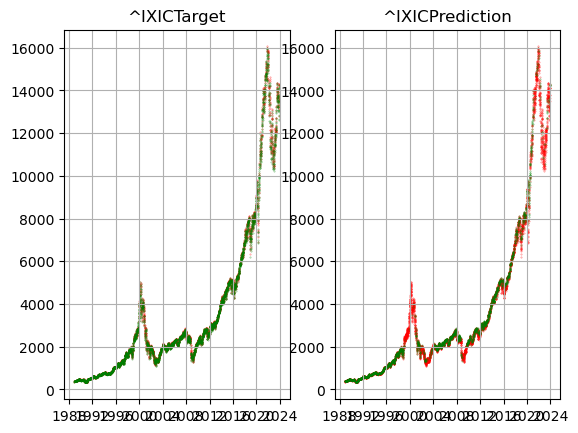

Red: Went-down; Green: Went-up; precision = 0.5823182711198428


In [95]:
#Not using Volatility features
nasdaq=stockpredictor("^IXIC")
p1=nasdaq.backtest()
#nasdaq.result(nasdaq.data.iloc[0:1])
nasdaq.plotter(p1)



C:\Users\sud4d\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


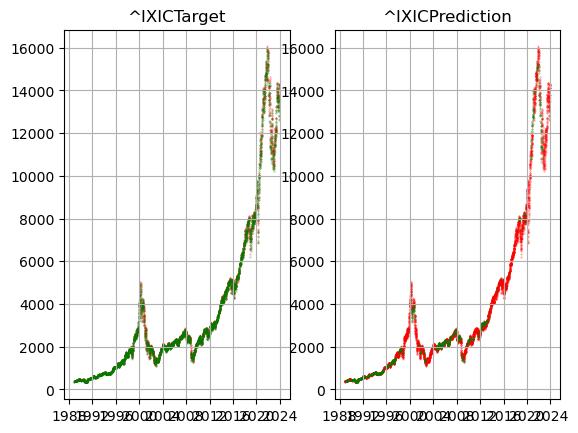

Red: Went-down; Green: Went-up; precision = 0.603836530442035


In [93]:
#Using Volatility features
nasdaq=stockpredictor("^IXIC")
p1=nasdaq.backtest()
#nasdaq.result(nasdaq.data.iloc[0:1])
nasdaq.plotter(p1)


In [96]:
#Including Volatility data over different rolling-windows, to help the regressor,  helps improve prediction from 58% to 60%

In [63]:
GOLD=stockpredictor("GC=F")


C:\Users\sud4d\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
########################################################################################

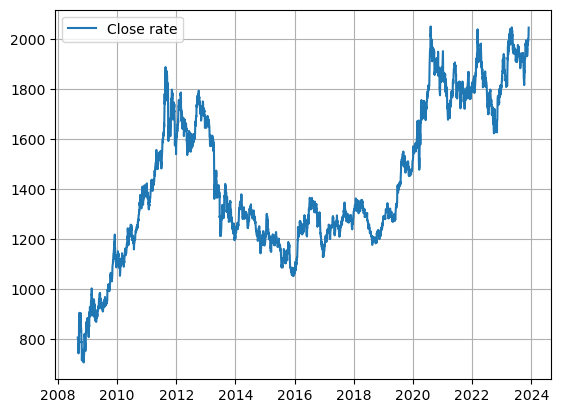

In [104]:

plt.plot(GOLD.data["Close"],label='Close rate')
plt.grid(which='major')
plt.legend()


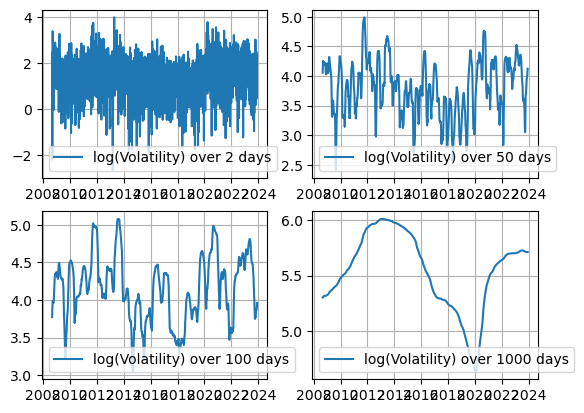

In [103]:
fig, axs = plt.subplots(2, 2)

h=[2,10,50,100,400,1000]

axs[0,0].plot(GOLD.data[f"Volat_{h[0]}"],label=f'log(Volatility) over {h[0]} days')
axs[0,0].grid(which='major')
axs[0,0].legend()

axs[0,1].plot(GOLD.data[f"Volat_{h[2]}"],label=f'log(Volatility) over {h[2]} days')
axs[0,1].grid(which='major')
axs[0,1].legend()

axs[1,0].plot(GOLD.data[f"Volat_{h[3]}"],label=f'log(Volatility) over {h[3]} days')
axs[1,0].grid(which='major')
axs[1,0].legend()

axs[1,1].plot(GOLD.data[f"Volat_{h[-1]}"],label=f'log(Volatility) over {h[-1]} days')
axs[1,1].grid(which='major')
axs[1,1].legend()

In [66]:
##########################################################